In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from numpy.matlib import zeros, ones, identity
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

# ICP #
This notebook is all about ICP and it's different implementations. It should be visual and self - descriptive.

## Overview ##
Having two scans $P = \{p_i\}$ and $Q = \{q_i\}$ we want to find a transformation (rotation $R$ and translation $t$) to apply to $P$ to match $Q$ as good as possible:

\begin{equation}
E = \sum_i[Rp_i + t - q_i]^2 \rightarrow \mathrm{min} 
\end{equation}

Here, we consider corresponding points. We will focus on **single iteration of icp** here.

## We plot data like this: ##

In [2]:
# plot the data
def plot_data(data_1, data_2, label_1='P', label_2='Q', xlim=[-5, 20], ylim=[-5, 20]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_p, y_p = data_1.A
    x_q, y_q = data_2.A
    ax.plot(x_p, y_p, color='blue', marker='o', label=label_1)
    ax.plot(x_q, y_q, color='red', marker='o', label=label_2)
    ax.legend()
    return ax

## Example data: ##

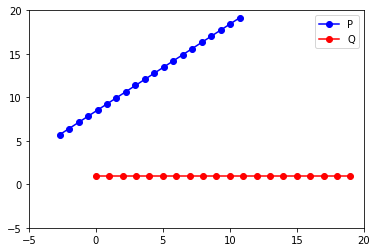

In [3]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.mat([[cos(angle), -sin(angle)], 
                 [sin(angle),  cos(angle)]])
t_true = np.mat([[-2], [5]])

# generate data as a list of 2d points
num_points = 20
Q = ones((2, num_points))
Q[0, :] = range(0, num_points)
P = R_true * Q + t_true
plot_data(P, Q)
plt.show()

## Centered data: ##

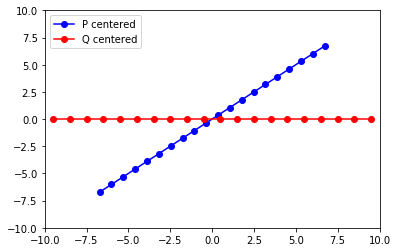

In [4]:
mu_P = P.mean(1)
mu_Q = Q.mean(1)
P_centered = P - mu_P
Q_centered = Q - mu_Q
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered',
               xlim=lim, ylim=lim)
plt.show()

## Correspondences: ##
We compute correspondences from $P$ to $Q$, i.e. for every $p_i$ we search the closest $q_j$ to it.

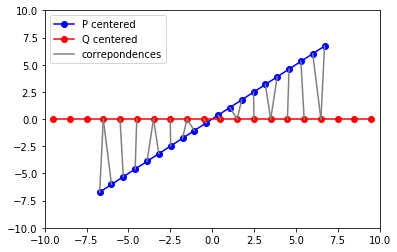

In [5]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

correspondences = get_correspondence_indices(P_centered, Q_centered)
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered',
               xlim=lim, ylim=lim)
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

## SVD - based ICP ##

#### Single iteration ####
In a single iteration we assume that the correspondences are known. We can compute the cross-correlation between the corresponding points. Let $C = \{\{i,j\}:p_i \leftrightarrow q_j\}$ be a set of all correspondences, also $|C| = N$. Then, the cross correlation $K$ is computed as:

\begin{eqnarray}
K &=& E [(q_i - \mu_Q)(p_i - \mu_P)^T] \\
&=& \frac{1}{N}\sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T} \\
&\sim& \sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T}
\end{eqnarray}

Each point has two dimentions, that is $p_i, q_j \in {\rm I\!R}$, thus cross correlation has the form of (we drop indices $i$ and $j$ for notation simplicity):

\begin{equation}
K =
  \begin{bmatrix}
    cov(p_x, q_x) & cov(p_x, q_y) \\
    cov(p_y, q_x) & cov(p_y, q_y)
  \end{bmatrix}
\end{equation}

Intuitevely, cross correlation tells us how a coordinate of point $q$ changes with the change of $p$ coorinate, i.e. $cov(p_x, q_x)$ tells us how the $x$ coordinate of $q$ will change with the change in $x$ coordinate of $p$ given that the points are corresponding. Ideal cross correlation matrix seems to be identity, i.e. we want the $x$ coordinates to be ideally correlated between the scans $P$ and $Q$, while there should be no correlation between the $x$ coorinate of points from $P$ to the $y$ coordinate of points in $Q$. 

**Example**: Given scans $P$ and $Q$ that match ideally and $\{p_i, q_j\} \in C$, we know that if we change the $x$ coordinate of $p_i$ we see exactly the same change in $x$ coordinate of $q_j$ while we observe no change in its $y$ coordinate. Therefore, the cross correlation matrix will be identity.

Knowing the cross correlation we can compute its SVD decomposition:

\begin{equation}
\mathrm{SVD}(K) = USV^T
\end{equation}

The SVD decomposition gives us how to rotate our data to align it with its prominent direction with $UV^T$ and how to scale it with its singular values $S$. Therefore:

\begin{eqnarray}
R &=& UV^T \\
t &=& \mu_Q - R \mu_P
\end{eqnarray}

#### Let's try this out: ####

## Compute cross covariance ##

In [6]:
def compute_cross_covariance(P, Q, correspondences):
    cov = zeros((2, 2))
    for i, j in correspondences:
        p_point = P[:, i]
        q_point = Q[:, j]
        cov += q_point * p_point.T
    return cov

cov = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[ 335.87572106  335.87572106]
 [   0.            0.        ]]


## Find $R$ and $t$ from SVD decomposition ##
Here we find SVD decomposition of the cross covariance matrix and apply the rotation to $Q$

In [7]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U * V_T
t_found = mu_Q - R_found * mu_P

[ 475.    0.]


## Apply correction to $P$ and visualize the result ##

[[-2.12132034]
 [-4.94974747]]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


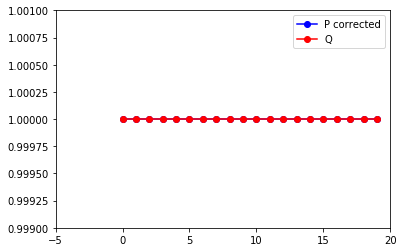

Squared diff: (P_corrected - Q) =  1.03387935784e-14


In [8]:
P_corrected = R_found * P + t_found
print(t_found)
print(R_found)
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q', ylim=[0.999, 1.001])
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

$\newcommand{\b}[1]{\boldsymbol{\mathrm{#1}}}$
$\newcommand{\R}{\boldsymbol{\mathrm{R}}}$
# Least-squares based ICP #
We can alternatively treat every iteration of ICP as a least squares minimization problem.

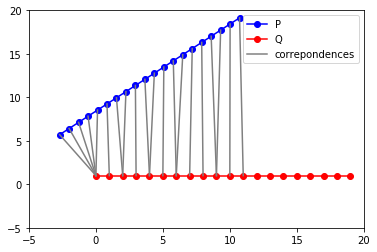

In [9]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q)
draw_correspondeces(P, Q, correspondences, ax)
plt.show()

## Idea ##
We model our error function as a sum of squared lengths of correspondences. This ensures, that we can treat this problem as least squares problem. We then need to compute a jacobian of such an error function and move in the direction to minimize it.

## State ##
We define our state $\b{x} \in \mathrm{SE(2)}$, i.e. $\b{x} = [x, y, \theta]^T$. This is the position to which we need to move scan $P$ so that points from it match scan $Q$. It is equivalent to $(\R, \b{t})$.

## Minimization ##
Let's define $\b{p}_i \in P$ to be points we want to match against $\b{q}_i \in Q$. By "matching" we mean we mean finding $\R$ and $\b{t}$, so that

\begin{equation}
\sum_{\{i, j\} \in C}{||\R_\theta \b{p}_i + \b{t} - \b{q}_j||^2} \rightarrow \min
\end{equation}

We will further use the following notation: $\b{h}_i(\b{x}) = \R_\theta \b{p}_i + \b{t}$ 

## Derivative computation ##
#### Rotation matrices ####
We define the rotation around 0 by angle $\theta$ by a rotation matrix $\R_\theta$. The derivative of such a matrix looks as follows:

\begin{equation}
\R_\theta^\prime
=\frac{\partial}{\partial \theta}
  \begin{bmatrix}
    \cos\theta & - \sin\theta \\
    \sin\theta & \cos\theta
  \end{bmatrix}
=\begin{bmatrix}
    -\sin\theta & - \cos\theta \\
    \cos\theta & -\sin\theta
  \end{bmatrix}
\end{equation}

In [10]:
def dR(theta):
    return np.matrix([[-sin(theta), -cos(theta)],
                      [cos(theta),  -sin(theta)]])

def R(theta):
    return np.matrix([[cos(theta), -sin(theta)],
                      [sin(theta),  cos(theta)]])

#### Jacobian ####
To minimize the squared error function we need to compute a Jacobian. We define the predicted positions of the transformed points as follows:

\begin{equation}
\b{h}_i(\b{x}) = \R_\theta \b{p}_i + \b{t},
\end{equation}

where $\b{t} = (x, y)$ - translational part of $\b{x}$ and $\b{p}_i = (p_i^x, p_i^y)$ is an observation of a point. This means that the Jacobian $\b{J}$ of $\b{h}$ is the following:

\begin{eqnarray}
\b{J} = \frac{\partial \b{h}_i(\b{x})}{\partial \b{x}} &=& \Big(\frac{\partial \b{h}_i(\b{x})}{\partial x}, \frac{\partial \b{h}_i(\b{x})}{\partial y}, \frac{\partial \b{h}_i(\b{x})}{\partial \theta}\Big) \\ &=&
\Big( \b{I}, \R_\theta^\prime \b{p}_i \Big) \\ &=&
\begin{bmatrix}
    1 & 0 & -\sin\theta\ p_i^x - \cos\theta\ p_i^y \\
    0 & 1 & \cos\theta\ p_i^x - \sin\theta\ p_i^y
\end{bmatrix}
\end{eqnarray}

In [11]:
def jacobian(x, p_point):
    theta = x[2]
    J = zeros((2, 3))
    J[0:2, 0:2] = identity(2)
    J[0:2, 2] = dR(theta) * p_point
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation * p_point + translation
    return prediction - q_point

## Least squares ##
Now that we know how to compute the Jacobian, we can compute the system of equations, solving which delivers the solution to our problem. We initialize $\b{H}$ and $\b{b}$ by zeros:

\begin{equation}
\b{H} = 
\begin{bmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 0
\end{bmatrix}, \ 
\b{b} = 
\begin{bmatrix}
    0 \\
    0 \\
    0
\end{bmatrix} \ 
\end{equation}

We now need to construct a system of equations solving which would give us the relative pose. **For every corresponding pair of points** do the following:

\begin{eqnarray}
\b{H} &\rightarrow& \b{H} + \b{J}^T \b{J} \\
\b{b} &\rightarrow& \b{b} + \b{J}^T \b{e}
\end{eqnarray}

Now that the system of equation is ready, we can find the $\Delta\b{x}$ - the solution to the least squares problem:

\begin{equation}
\b{H} \Delta\b{x} = -\b{b} \Longrightarrow \Delta\b{x} = -\b{H}^{-1}\b{b}
\end{equation}

This can be solved without actually inverting the matrix in reality.

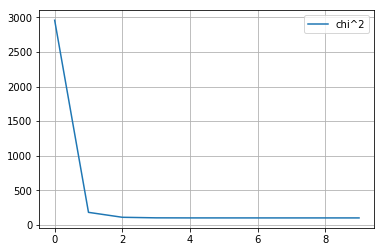

[2957.5185437703685, 182.99242393806952, 111.7510737443065, 103.68031317942031, 102.70682822107159, 102.57232864649896, 102.55319159322751, 102.55045645613349, 102.55006528686955, 102.5500093380821]


In [12]:
def prepare_system(x, P, Q, correspondences):
    H = zeros((3, 3))
    b = zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, i]
        q_point = Q[:, j]
        e = error(x, p_point, q_point)
        J = jacobian(x, p_point)
        H += J.T * J
        b += J.T * e
        chi += e.T * e
    return H, b, chi

def icp(P, Q, correspondences):
    x = zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]
    for i in range(10):
        H, b, chi = prepare_system(x, P, Q, correspondences)
        dx = np.linalg.lstsq(H, -b)[0]
        x += dx
        # normalize angle
        x[2] = atan2(sin(x[2]), cos(x[2]))
        # add error to list of errors
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
    return x, chi_values, x_values

x, chi_values, x_values = icp(P, Q, correspondences)
plt.plot(chi_values, label="chi^2")
plt.legend()
plt.grid(True)
plt.show()
print(chi_values)


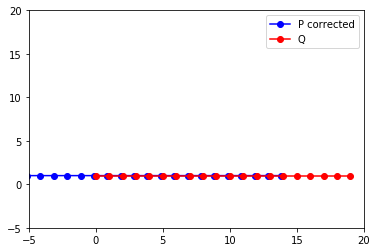

Squared diff: (P_corrected - Q) =  23.0315004418


In [13]:
theta = x[2]
R_found = np.matrix([[cos(theta), -sin(theta)],
                     [sin(theta), cos(theta)]])
t_found = x[0:2]
P_corrected = R_found * P + t_found

ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

In [14]:
# First set up the figure, the axis, and the plot element we want to animate
fig, anim_ax = plt.subplots()

anim_ax.set_xlim(( -5, 20))
anim_ax.set_ylim((-5, 20))
x_q, y_q = Q.A
Q_line, = anim_ax.plot(x_q, y_q, 'ro')
P_line, = anim_ax.plot([], [], 'bo')

# animation function. This is called sequentially
def animate(i):
    x = x_values[i]
    rot = R(x[2])
    t = x[0:2]
    P_inc = rot * P + t
    x_p, y_p = P_inc.A
    P_line.set_data(x_p, y_p)
    return (P_line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=len(x_values), interval=500, blit=True)
HTML(anim.to_html5_video())